In [1]:
from projectlib.imports import *
from projectlib.datasets import fashion_mnist

In [2]:
input_shape = fashion_mnist.input_shape
noise_dim = 128

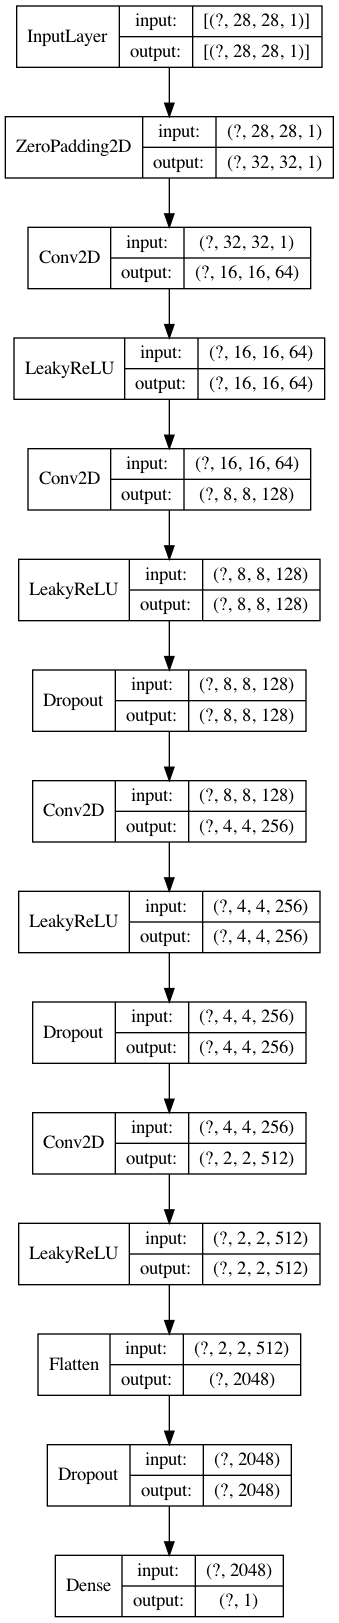

In [3]:
def get_discriminator(input_shape):
    img_input = Input(shape=input_shape)
    x = ZeroPadding2D((2, 2))(img_input)
    
    x = Conv2D(filters=64, kernel_size=5, strides=(2,2), padding='same', use_bias=True)(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=128, kernel_size=5, strides=(2,2), padding='same', use_bias=True)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=256, kernel_size=5, strides=(2,2), padding='same', use_bias=True)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=512, kernel_size=5, strides=(2,2), padding='same', use_bias=True)(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    logit = Dense(1)(x)
    
    return Model(img_input, logit, name="discriminator")
discriminator = get_discriminator(input_shape)
#plot_model(discriminator, show_shapes=True, show_layer_names=False, expand_nested=True)

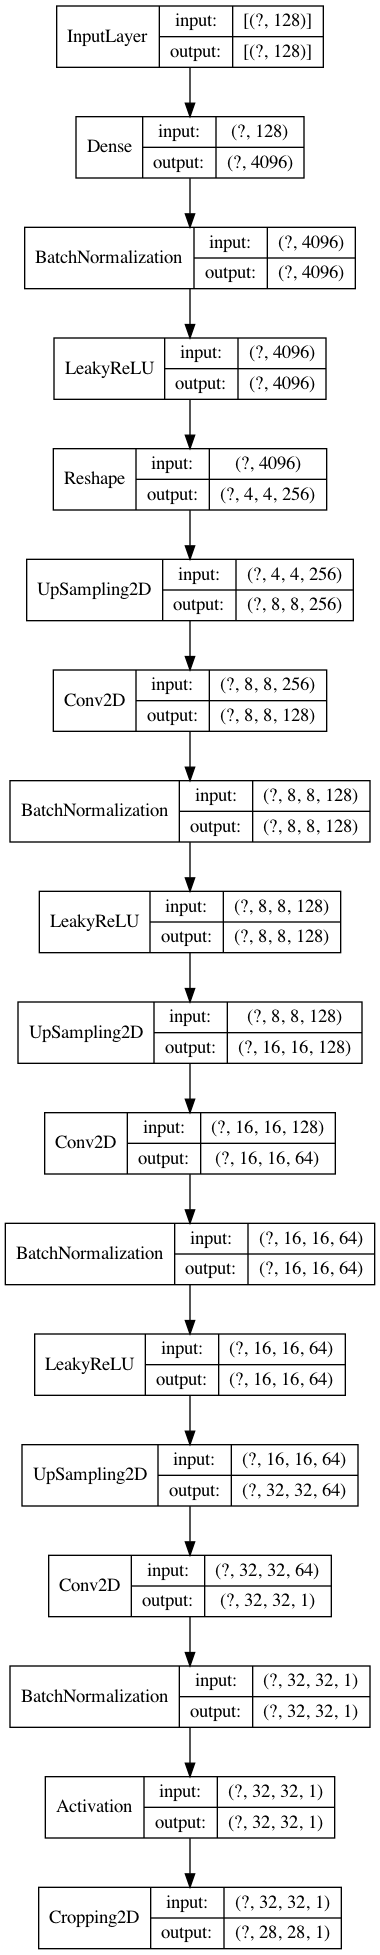

In [4]:
def get_generator(noise_dim):
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Reshape((4, 4, 256))(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters=1, kernel_size=3, strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    fake_image = Cropping2D((2, 2))(x)

    g_model = Model(noise, fake_image, name="generator")
    return g_model


generator = get_generator(noise_dim)
#plot_model(generator, show_shapes=True, show_layer_names=False, expand_nested=True)

In [8]:
class WGAN(Model):
    def __init__(self,
                 discriminator,
                 generator,
                 latent_dim,
                 discriminator_steps=3,
                 gradient_penalty_weight=10.0):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.discriminator_steps = discriminator_steps
        self.gradient_penalty_weight = gradient_penalty_weight

    def compile(self, discriminator_loss_fn, generator_loss_fn):
        super(WGAN, self).compile()
        self.discriminator_loss_fn = discriminator_loss_fn
        self.generator_loss_fn = generator_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
        return gradient_penalty

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss

        for i in range(self.discriminator_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                discriminator_cost = self.discriminator_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gradient_penalty = self.gradient_penalty(batch_size, real_images, fake_images)
                discriminator_loss = discriminator_cost + gradient_penalty * self.gradient_penalty_weight

            discriminator_gradients = tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
            self.discriminator.optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_logits = self.discriminator(fake_images, training=True)
            generator_loss = self.generator_loss_fn(fake_logits)

        generator_gradients = tape.gradient(generator_loss, self.generator.trainable_variables)
        self.generator.optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        return {"d_loss": discriminator_loss, "g_loss": generator_loss}


In [9]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = tf.keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


In [10]:
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9))
generator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9))

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


batch_size = 128
epochs = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(discriminator, generator, latent_dim=noise_dim, discriminator_steps=3,)

# Compile the wgan model
wgan.compile(
    discriminator_loss_fn=discriminator_loss,
    generator_loss_fn=generator_loss,
)

# Start training
X, y = fashion_mnist.load_data(frac=0.01)
wgan.fit(X, batch_size=batch_size, epochs=epochs, callbacks=[cbk])


Epoch 1/20
1/6 [====>.........................] - ETA: 0s - d_loss: -4.2354 - g_loss: 5.2396

KeyboardInterrupt: 